In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import os
import itertools

import pickle
from skimage.feature import hog
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import collections

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from sklearn.externals import joblib
from pipelineFunctions import *


%matplotlib inline


/home/pepelepoe/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load training data from pickle

In [2]:
data = joblib.load('models/svc_01.pkl')
# data = joblib.load('models/clf_9869.pkl')
# svc = data['model']
svc = data['model']
config = data['config']

color_space = config['color_space']
spatial_size = config['spatial_size']
hist_bins = config['hist_bins']
orient = config['orient']
pix_per_cell = config['pix_per_cell']
cell_per_block = config['cell_per_block']
hog_channel = config['hog_channel']
spatial_feat = config['spatial_feat']
hist_feat = config['hist_feat']
hog_feat = config['hog_feat']
X_scaler = config['X_scaler']
print(config)

{'color_space': 'YCrCb', 'cell_per_block': 2, 'hog_feat': True, 'hist_bins': 128, 'pix_per_cell': 8, 'X_scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'hog_channel': 'ALL', 'orient': 9, 'hist_feat': True, 'spatial_size': (16, 16), 'spatial_feat': True}


## Find windows

In [3]:
# triangle = [((64, 64),  [400, 500]),
#            ((96, 96),  [400, 500]),
#            ((128, 128),[450, 578]),
#            ((192, 192),[450, None]),
#       ]
triangle = [((64, 64),  [400, 500]),
           ((96, 96),  [400, 600]),
           ((128, 128),[450, 700]),
           ((192, 192),[450, None]),
      ]

# print(triangle)
# print(type(triangle))
# print(len(triangle))
image_size = (720, 1280)

# img = mpimg.imread('./test_images/test5.jpg')


# vertices = np.array([[(0, image_size[0]), (0,image_size[0]/2), (image_size[1], image_size[0]/2), (image_size[1], image_size[0])]], dtype=np.int32)
# vertices = vertices.reshape((-1,1,2))
# trinagle = cv2.polylines(img,[vertices],True,(255,0,0), 4)
# plt.imshow(trinagle)
windows = create_windows(triangle, image_size)

### Process frame

In [4]:
#Borrowed from https://github.com/thomasantony/CarND-P05-Vehicle-Detection.git
from pipelineFunctions import *
def process_frame(image, params):
    config, clf, all_windows = params['clf_config'], params['clf'], params['windows']

    if params['cache_enabled']:
        cache = process_frame.cache
        if cache['heatmaps'] is None:
            cache['heatmaps'] = collections.deque(maxlen=params['heatmap_cache_length'])
        windows = itertools.chain(*all_windows)
    else:
        windows = itertools.chain(*all_windows)

    measurements = window_detect(image, clf, config, windows, params['decision_threshold'])
    current_heatmap = update_heatmap(measurements, image.shape)
    if not params['cache_enabled']:
        thresh_heatmap = current_heatmap
    else:
        cache['heatmaps'].append(current_heatmap)
        thresh_heatmap = sum(cache['heatmaps'])
    
    thresh_heatmap[thresh_heatmap < params['heatmap_threshold']] = 0
    cv2.GaussianBlur(thresh_heatmap, (31,31), 0, dst=thresh_heatmap)

    labels = label(thresh_heatmap)
    labeledBoxed = draw_labeled_bboxes(np.copy(image), labels)
    return labeledBoxed

def clear_cache():
    process_frame.cache = {
        'meas': None,
        'heatmaps': None,
        'frame_ctr': 0
    }

### Test on images

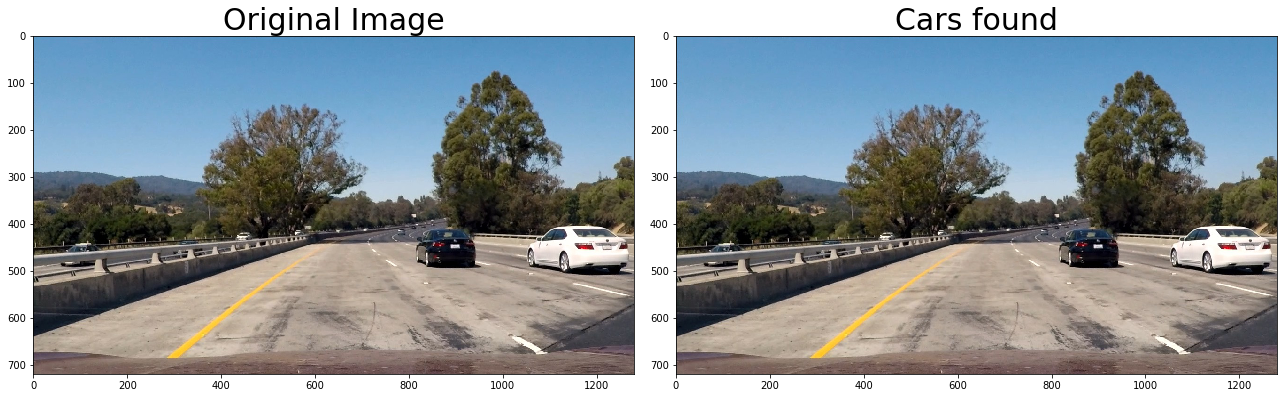

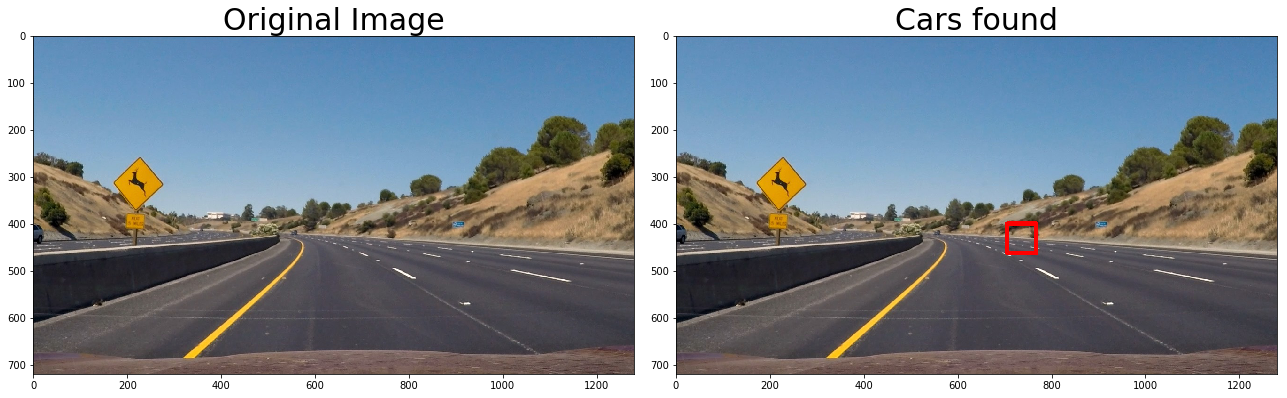

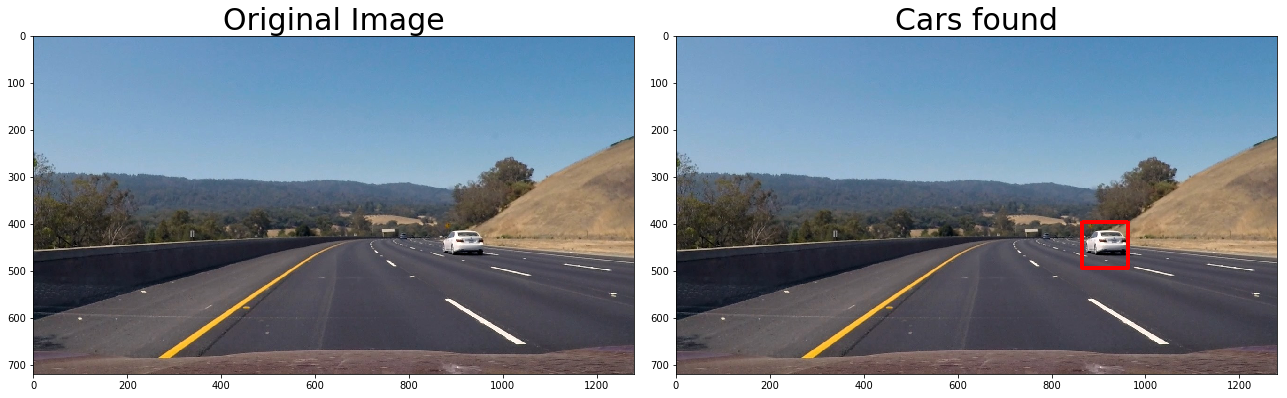

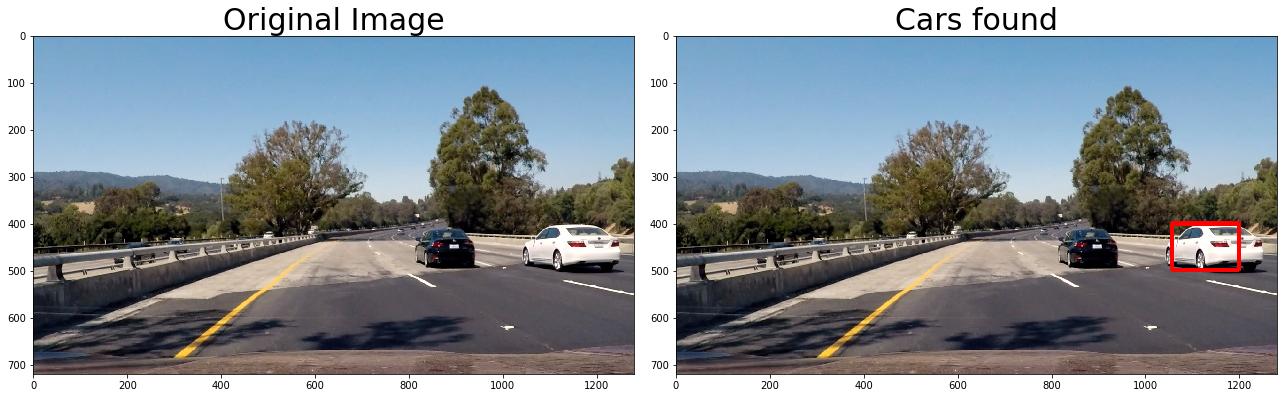

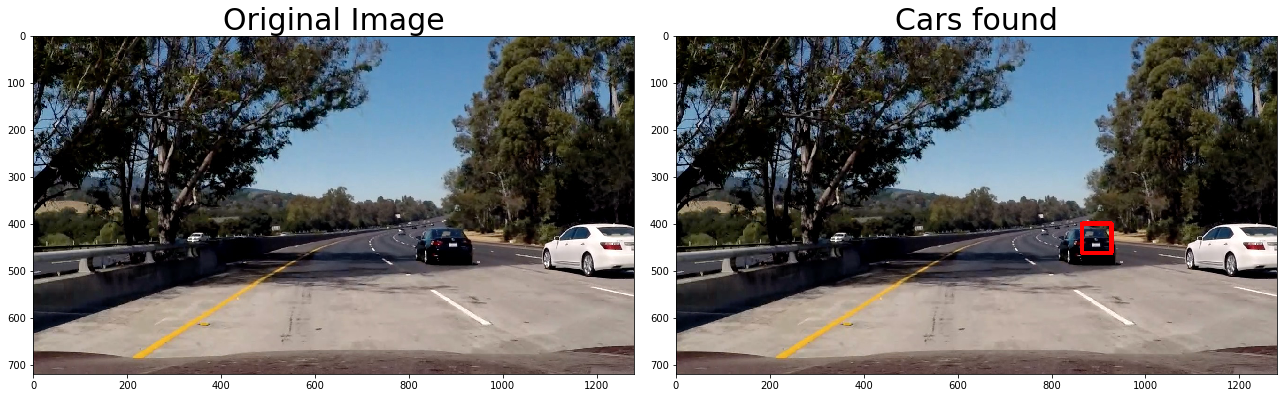

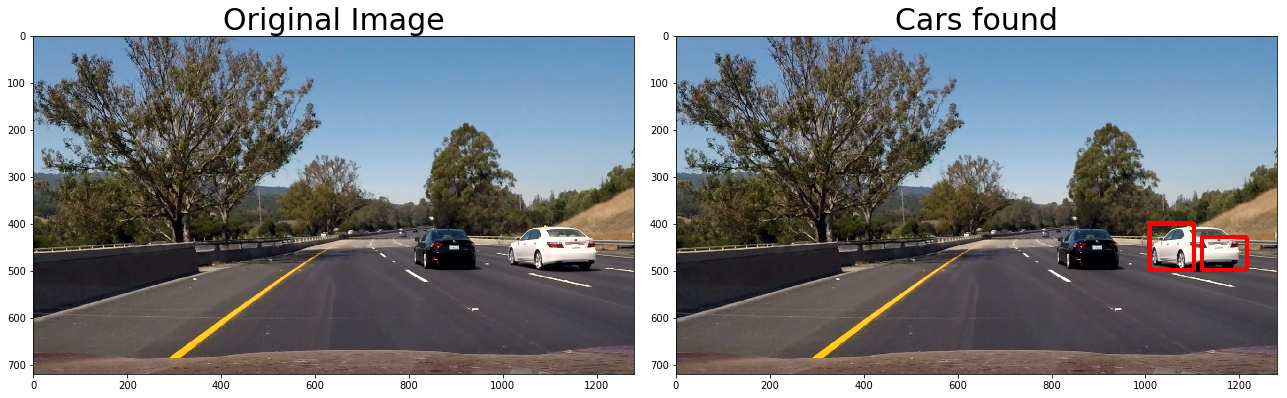

In [5]:
clear_cache()
params = {}
params['clf_config'] = config
params['clf'] = svc
params['windows'] = windows
params['cache_enabled'] = False
params['heatmap_cache_length'] = 5
params['heatmap_threshold'] = 1
params['decision_threshold'] = 1

for i in range(1,7):
    image = mpimg.imread('test_images/test{}.jpg'.format(i))
#     image = image.astype(np.float32)/255

    window_img = process_frame(image, params)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(window_img)
    ax2.set_title('Cars found', fontsize=30)
#     plt.savefig('output_images/sliding_window.png', bbox_inches="tight")
    # plt.imshow(window_img)
    plt.show()
#     plt.imshow(im2)

### Test on video

In [ ]:
from datetime import datetime
print("Start time: ", datetime.now().time())
clear_cache()

params = {}
params['clf_config'] = config
params['clf'] = svc
params['windows'] = windows
params['cache_enabled'] = True
params['heatmap_cache_length'] = 30
params['heatmap_threshold'] = 4
params['decision_threshold'] = 0.5

t = time.time()

test_out_file = 'test_video_out.mp4'
# clip_test = VideoFileClip('test_video.mp4')
clip_test = VideoFileClip('project_video.mp4').subclip(10, 20)
# clip_test = VideoFileClip('project_video.mp4')

# clip_test_out = clip_test.fl_image(process_frame)
clip_test_out = clip_test.fl_image(lambda x: process_frame(x, params))

%time clip_test_out.write_videofile(test_out_file, audio=False)

t2 = time.time()
print(round(t2 - t, 5), 'Seconds to process video.')
print("End time: ", datetime.now().time())
print('\007')




Start time:  18:07:47.491271
[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 27%|██▋       | 69/251 [01:05<02:53,  1.05it/s]